# Final project -  SMS Spam Classification

## Data set
The data that will be used for this project is SMS Spam Collection dataset, which contains SMS text examples (5574 SMS phone messages) and their corresponding labels (or tags: Spam and Ham).  
The file contains one message per line. Each line consists of two columns: 'v1' contains the label (ham or spam) and 'v2' contains the raw text.
Link: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

## Technique
Bi-directional LSTM is used as a classifier to detect spam messages.

For trained model:
- Input: a text message
- Output: category spam or ham

The following parts are shown the steps by steps to build the model.

# Agenda
1. Import required libraries and dataset
2. Explore Data
3. Data prepareration
4. Text-processing
5. Model Building
6. Model saving and predict checking

# 1. Import required libraries and dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#make sure your environment have tensorflow 2.4 or higher 2.0
!pip install nltk
!pip install wordcloud
!pip install tensorflow==2.4


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import nltk, re, collections, pickle, os # nltk - Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# %matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')
seed = 42

import warnings
warnings.filterwarnings(action = "ignore")
warnings.simplefilter(action = 'ignore', category = Warning)
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

#True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#read data from csv file to dataframe
df_spam = pd.read_csv('/content/drive/MyDrive/SPAM Classification/spam.csv', encoding = 'latin-1')
df_spam.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df_spam.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


# 2. Explore Data

In [ ]:
#rename  (v1, v2) columns
df_spam = df_spam.filter(['v1', 'v2'], axis = 1)
print(df_spam.columns)
df_spam.columns = ['feature', 'message']
df_spam.drop_duplicates(inplace = True, ignore_index = True)
print('Number of null values:\n')
df_spam.isnull().sum()

Index(['v1', 'v2'], dtype='object')
Number of null values:



feature    0
message    0
dtype: int64

In [ ]:
#Total sample in each labels
print('Total ham(0) and spam(1) messages')
df_spam['feature'].value_counts()
df_spam.describe().T

Total ham(0) and spam(1) messages


,count,unique,top,freq
feature,5169,2,ham,4516
message,5169,5169,"Go until jurong point, crazy.. Available only ...",1


# Dataset statistics

Fig1-Plot the number of value of both 'spam' and 'ham' messages

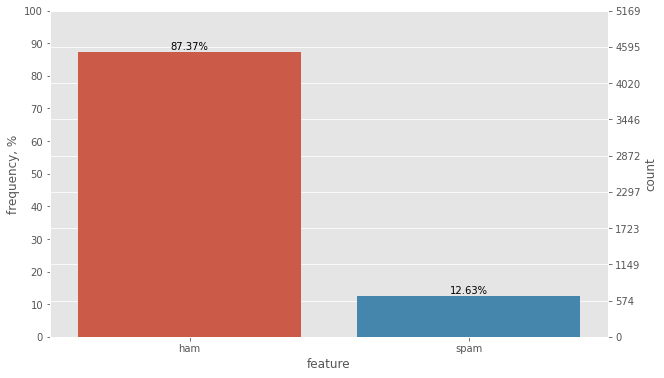

In [ ]:
plt.figure(figsize = (10, 6))
counter = df_spam.shape[0] #Total 

ax1 = sns.countplot(df_spam['feature'])
ax2 = ax1.twinx()                      
ax2.yaxis.tick_left()                 
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')  
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('frequency, %')

for p in ax1.patches:
  x = p.get_bbox().get_points()[:, 0]
  y = p.get_bbox().get_points()[1, 1]
  ax1.annotate('{:.2f}%'.format(100. * y / counter),
              (x.mean(), y),
              ha = 'center',
              va = 'bottom')

# Use a LinearLocator to ensure the correct number of ticks
ax1.yaxis.set_major_locator(ticker.LinearLocator(10))

# Fix the frequency range to 0-100
ax2.set_ylim(0, 100)
ax1.set_ylim(0, counter)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

ax2.grid(None)

Fig2 - Plot the number of different most often used words present in dataset

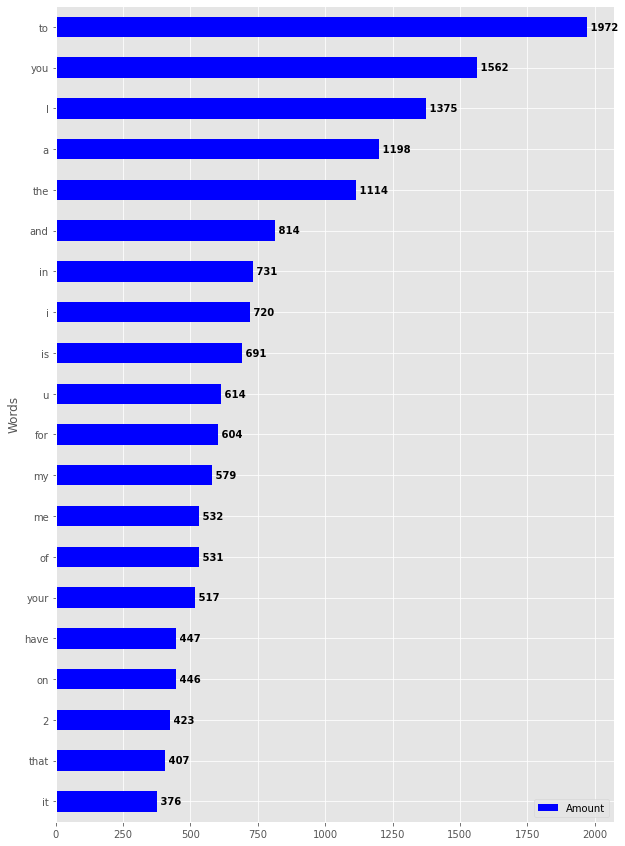

In [ ]:
def plot_words(set, number):
  words_counter = collections.Counter([word for sentence in set for word in sentence.split()]) # finding words along with count
  most_counted = words_counter.most_common(number)
  most_count = pd.DataFrame(most_counted, columns = ["Words", "Amount"]).sort_values(by = "Amount") # sorted data frame
  most_count.plot.barh(x = "Words", 
                       y = "Amount",
                       color = "blue",
                       
                       figsize = (10, 15))
  for i, v in enumerate(most_count["Amount"]):
    plt.text(v, i,
             " " + str(v),
             color = 'black',
             va = 'center',
             fontweight = 'bold')
    
plot_words(df_spam['message'], number = 20) #number of words in the range of [5 ..50]

word cloud of spam class


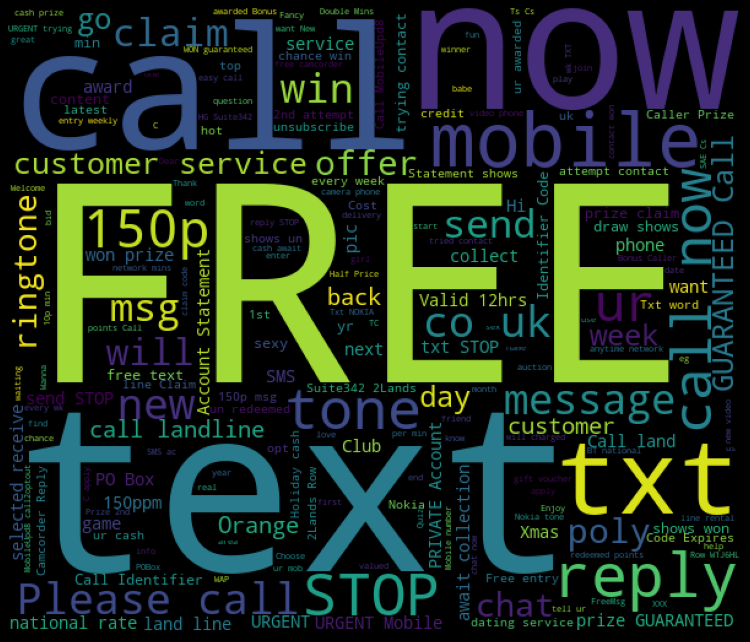

word cloud of ham class


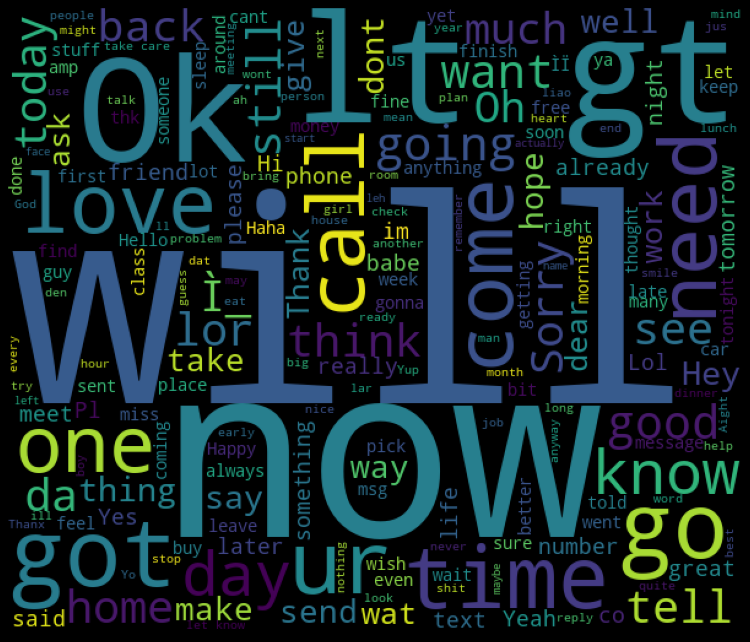

In [ ]:
#word_cloud visualization
def word_cloud(tag):
  df_words_nl = ' '.join(list(df_spam[df_spam['feature'] == tag]['message']))
  df_wc_nl = WordCloud(width = 600, height = 512).generate(df_words_nl)
  plt.figure(figsize = (13, 9), facecolor = 'k')
  plt.imshow(df_wc_nl)
  plt.axis('off')
  plt.tight_layout(pad = 1)
  plt.show()

print('word cloud of spam class')
word_cloud('spam')
print('word cloud of ham class')
word_cloud('ham')

# 3.  Data prepareration

This stage of preparing data sets to the new deep learning model for the SPAM classification task includes:
- training: for training a pre-built model
- validation: is used for finding better hyperparameters
- test sets: a test set will be used for checking the trained model on data that the model did not see


### 3.1 Data split

In [ ]:
#define some input parameters
test_size, valid_size = 0.1, 0.2

In [ ]:
sentences_new_set = []
labels_new_set = []
for i in range(0, df_spam.shape[0], 1):
    sentences_new_set.append(df_spam['message'][i])
    labels_new_set.append(df_spam['feature'][i])

#number of sample in each set
train_size = int(df_spam.shape[0] * (1 - test_size - valid_size))
valid_bound = int(df_spam.shape[0] * (1 - valid_size))

#train_set, valid_set, test_set
train_sentences = sentences_new_set[0 : train_size] # first 70% of sample use for train_set
valid_sentences = sentences_new_set[train_size : valid_bound] #next 20% use for valid_set
test_sentences = sentences_new_set[valid_bound : ] #final 10% of sample use for test set

#train_label, valid_label, test_lable
train_labels_str = labels_new_set[0 : train_size]
valid_labels_str = labels_new_set[train_size : valid_bound]
test_labels_str = labels_new_set[valid_bound : ]

### 3.2 Labels transformations

All the labels (with the following values: ham-1 and spam-0) are replaced to the appropriate values 1 and 0, and transform them to Numpy arrays.

In [ ]:
def label_data(dataset):
  dataset_label = [0] * len(dataset)
  for ind, item in enumerate(dataset):
    if item == 'ham':
        dataset_label[ind] = 1
  return dataset_label

train_labels =  label_data(train_labels_str)        
valid_labels = label_data(valid_labels_str)
test_labels = label_data(test_labels_str)


train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

# 4.Text-processing

### 4.1 Tokenization 

In [ ]:
#define some input parameters
size_vocabulary = 1000    #num_word parameter in tokenizer
oov_token = "<OOV>"       # Out Of Vocab token 
trunc_type = "post"       # pad_sequences parameter
padding_type = "post"     # pad_sequences parameter

Hyper-parameters used in Tokenizer object are: num_words and oov_token.


In [ ]:
tokenizer = Tokenizer(num_words = size_vocabulary, #num_word: for maximum number of unique tokens
                      oov_token = oov_token,       #
                      lower = False)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
#word_index

## 4.2 Sequencing and Padding

- padding = 'pre' or 'post' (post is set). Pre'll pad before each sequence and post will pad after each sequence.
- maxlen = maximum length of all sequences.
- truncating = 'pre' or 'post' (post is set). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. 'pre' option will truncate at the beginning where as 'post' will truncate at the end of the sequences.

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
size_voc = len(word_index) + 1
max_len = max([len(i) for i in train_sequences])
train_set = pad_sequences(train_sequences,
                                padding = padding_type,
                                maxlen = max_len,
                                truncating = trunc_type) 

valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
valid_set = pad_sequences(valid_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_set = pad_sequences(test_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

In [ ]:
print(max_len)

189


# 5. Model Building

### 5.1 Model building

In [ ]:
embedding_dimension = 64
drop_level = 0.1
num_epochs = 20

In [ ]:
model = Sequential([
    Embedding(size_voc, embedding_dimension, input_length = max_len),  # embedding layer
    Bidirectional(LSTM(100)),                                          # bi-lstm layer
    Dropout(drop_level), 
    Dense(20, activation = 'relu'),                                    # Dense layer
    Dropout(drop_level),
    Dense(1, activation = 'sigmoid')
])


### 5.2 Model compiling and fitting

In [ ]:
# Add loss function, metrics, optimizer

optim = Adam(learning_rate = 0.0001)

model.compile(loss = 'binary_crossentropy',
              optimizer = optim,
              metrics = ['accuracy'])
# Adding callbacks - using early stopping to save training time.
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1,patience=3)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 189, 64)           583872    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               132000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                4020      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 719,913
Trainable params: 719,913
Non-trainable params: 0
________________________________________________

Model training

### 5.3 Model Training

In [ ]:
history = model.fit(train_set, 
                    train_labels,
                    epochs = num_epochs, 
                    validation_data = (valid_set, valid_labels),
                    workers = os.cpu_count(),
                    callbacks=[es],
                    use_multiprocessing = True,
                    verbose = 1)

Epoch 1/20
114/114 [==============================] - 18s 33ms/step - loss: 0.6420 - accuracy: 0.7329 - val_loss: 0.4019 - val_accuracy: 0.8607
Epoch 2/20
114/114 [==============================] - 3s 24ms/step - loss: 0.3895 - accuracy: 0.8638 - val_loss: 0.3135 - val_accuracy: 0.8607
Epoch 3/20
114/114 [==============================] - 3s 23ms/step - loss: 0.2536 - accuracy: 0.8853 - val_loss: 0.2313 - val_accuracy: 0.9284
Epoch 4/20
114/114 [==============================] - 3s 23ms/step - loss: 0.1982 - accuracy: 0.9311 - val_loss: 0.1887 - val_accuracy: 0.9381
Epoch 5/20
114/114 [==============================] - 3s 24ms/step - loss: 0.1220 - accuracy: 0.9649 - val_loss: 0.1493 - val_accuracy: 0.9516
Epoch 6/20
114/114 [==============================] - 3s 24ms/step - loss: 0.0960 - accuracy: 0.9733 - val_loss: 0.0940 - val_accuracy: 0.9710
Epoch 7/20
114/114 [==============================] - 3s 23ms/step - loss: 0.0823 - accuracy: 0.9796 - val_loss: 0.0771 - val_accuracy: 0.974

### 5.4 Results visualization

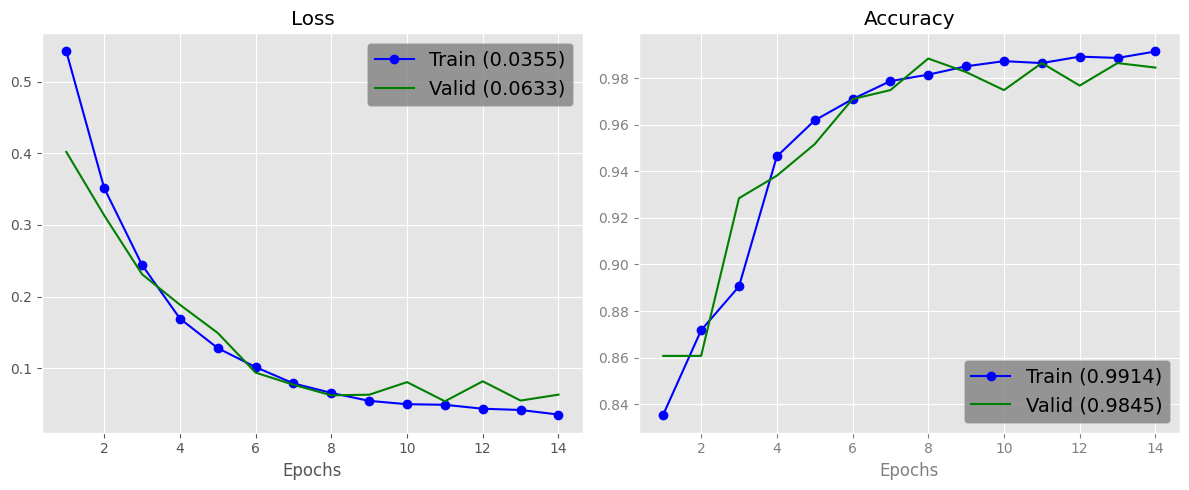

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' in s]
    
    plt.figure(figsize = (12, 5), dpi = 100)
    COLOR = 'gray'
    
    plt.rc('legend', fontsize = 14)   # legend fontsize
    plt.rc('figure', titlesize = 12)  # fontsize of the figure title
        
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.subplot(1, 2, 1)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    
    ## Accuracy
    plt.subplot(1, 2, 2)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(format(history.history[l][-1],'.4f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(format(history.history[l][-1],'.4f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
model_score = model.evaluate(test_set, test_labels, batch_size = embedding_dimension, verbose = 1)
print(f"Test accuracy: {model_score[1] * 100:0.2f}% \t\t Test error: {model_score[0]:0.4f}")

17/17 [==============================] - 0s 14ms/step - loss: 0.0587 - accuracy: 0.9826
Test accuracy: 98.26% 		 Test error: 0.0587


# 6. Model saving and predict checking 

### 6.1 Model saving

We can save the trained model and tokenizer for future uses in different formats.

In [ ]:
model_name = "spam_classifier"
pickle.dump(tokenizer, open(model_name + ".pkl", "wb"))
filepath = model_name + '.h5'
tf.keras.models.save_model(model, filepath, include_optimizer = True, save_format = 'h5', overwrite = True)
print("Size of the saved model :", os.stat(filepath).st_size, "bytes")

Size of the saved model : 8695176 bytes


More evaluation metrics from confusion matrix

In [ ]:
import itertools
def plot_conf_matr(conf_matr, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.winter):
   


  accuracy = np.trace(conf_matr) / np.sum(conf_matr).astype('float')
  sns.set(font_scale = 1.4)

  plt.figure(figsize = (12, 8))
  plt.imshow(conf_matr, interpolation = 'nearest', cmap = cmap)
  title = '\n' + title + '\n'
  plt.title(title)
  plt.colorbar()

  if classes is not None:
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation = 45)
      plt.yticks(tick_marks, classes)

  if normalize:
      conf_matr = conf_matr.astype('float') / conf_matr.sum(axis = 1)[:, np.newaxis]


  thresh = conf_matr.max() / 1.5 if normalize else conf_matr.max() / 2
  for i, j in itertools.product(range(conf_matr.shape[0]), range(conf_matr.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.2f}%".format(conf_matr[i, j] * 100),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(conf_matr[i, j]),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\n\nAccuracy = {:0.2f}%; Error = {:0.2f}%'.format(accuracy * 100, (1 - accuracy) * 100))
  plt.show()

Confusion Matrix for bLSTM (the threshold value (0.5) which will help us to mark correctly and incorrectly predicted labels)

			Classification report:

               precision    recall  f1-score   support

           0       0.99      0.85      0.92       117
           1       0.98      1.00      0.99       917

    accuracy                           0.98      1034
   macro avg       0.99      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034
 



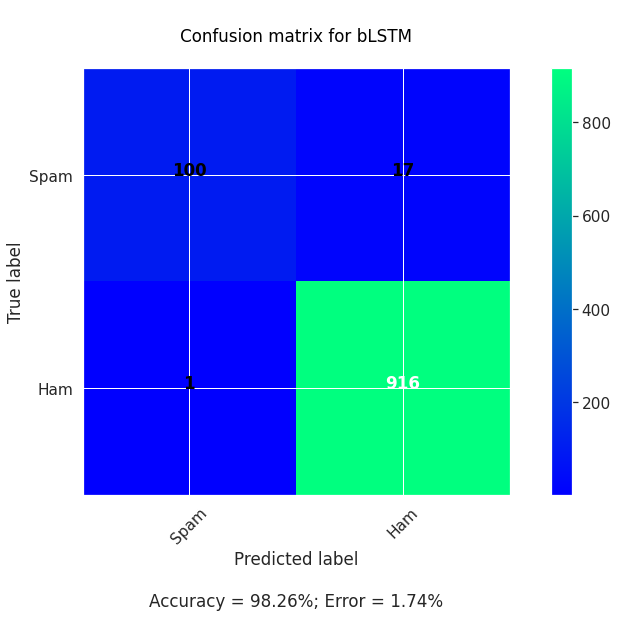

In [ ]:
y_pred = model.predict(test_set)
threshold = 0.5
y_prediction = [0] * y_pred.shape[0]
for ind, item in enumerate(y_pred):
    if item > threshold:
        y_prediction[ind] = 1
    else:
        y_prediction[ind] = 0

conf_matrix = confusion_matrix(test_labels, y_prediction)
class_rep_bLSTM = classification_report(test_labels, y_prediction)
print('\t\t\tClassification report:\n\n', class_rep_bLSTM, '\n')
plot_conf_matr(conf_matrix, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for bLSTM')

### 6.2 Prediction on the real messages

Let's check trained model on the real messages which you can create yourself.

In [ ]:
# You can change this message (as any short sentence)
# For example
t1 = time.time()
message_example = ["Think ur smart ? Win å£200 this week in our weekly quiz, text PLAY to 85222 now!T&Cs WinnersClub PO BOX 84, M26 3UZ. 16+. GBP1.50/week"] 
#message_example = ["Darling, please give me a cup of tea"] 

message_example_tp = pad_sequences(tokenizer.texts_to_sequences(message_example),
                                   maxlen = max_len,
                                   padding = padding_type,
                                   truncating = trunc_type)

pred = float(model.predict(message_example_tp))
if (pred > threshold):
    print ("This message is a real text")
else:
    print("This message is a spam message")
    
t2 = time.time()

predict_time = t2 - t1
print("Predict time:" + str(predict_time))

This message is a spam message
Predict time:0.04805350303649902
